In [ ]:
!pip install OpenBlender

In [2]:
# Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import pandas as pd
import OpenBlender
import json
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import timeit
#start_time = timeit.default_timer()

__________

### Using Open Blender ###

pre-covid period
'date_filter':{"start_date":"2019-04-08T00:00:00.000Z",
                     "end_date":"2019-12-09T0:00:00.000Z"},

In [4]:
# pre-period 4/8/19~12/9/19
# Specify the action
action = 'API_getObservationsFromDataset'
# Specify your Token 
token = '5fcf78e29516296fad52cb45GfJgCsWWcabzq9TZsfnRU0TqBPK3wG'

interval = 60 * 60 * 24 # One day
parameters = { 
 'token' : token,
    ##'id_dataset':'5d4ca8709516290b01c9d725', #microsoft
    'id_dataset':'5d4c39d09516290b01c8307b', #apple
    'date_filter':{"start_date":"2019-04-08T00:00:00.000Z",
                     "end_date":"2019-12-09T0:00:00.000Z"},
    'aggregate_in_time_interval' : {
              'time_interval_size' : interval, 
              'output' : 'avg', 
              'empty_intervals' : 'impute'
      }
}
        
# Pull the data into a Pandas Dataframe
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False)
df.reset_index(drop=True, inplace=True)
df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]
#df = df.drop('timestamp', axis = 1)
#df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]
#df = df.drop('timestamp', axis = 1)


Task ID: '5fcf79070895fafb4a9d8d4b'.
Total estimated consumption: 5867.89 processing units.
Task confirmed. Starting download..
100.0 % completed.


In [5]:
positive_filter = {'name' : 'apple', 
                   'match_ngrams': ['apple', 'iphone', 'ipad', 
                                    'tim cook', 'mac store','mac','silicon']}

# We need to pass the 'id_dataset', the name of the
# column (which is 'text') and an optional filter.
blend_source = {
                'id_dataset':'5e2ef74e9516294390e810a9',#Wall Street Journal Twitter
                'feature' : 'text',
                'filter_text' : positive_filter
            }
df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = df.timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list')
df_anchor = pd.concat([df, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
df_anchor.head()

Task ID: '5fcf79100895fafb4a9d8d4c'.
Total estimated consumption: 9800.0 processing units.
Task confirmed. Starting download..
100%


,change,count_agg,high,low,open,price,timestamp,date,WALL_STREE.text_COUNT_last1days:apple,WALL_STREE.text_last1days:apple
0,1.776667,0,269.296667,265.903333,266.173333,269.00,1575763200,08-12-2019 00:00:00,0,[]
1,1.930000,1,271.000000,267.480000,267.480000,270.71,1575676800,07-12-2019 00:00:00,1,"[actress allison mack of ""smallville"" pleaded ..."
2,1.340000,1,267.950000,265.370000,265.710000,267.84,1574899200,28-11-2019 00:00:00,1,[walmart will expand the use of machines to sc...
3,1.690000,1,209.360000,206.720000,208.490000,209.01,1567123200,30-08-2019 00:00:00,0,[]
4,0.670000,1,205.700000,203.320000,204.330000,205.53,1567036800,29-08-2019 00:00:00,1,[science is a favorite subject for novelist ia...


Creating a text vectorizer

In [6]:
action = 'API_createTextVectorizerPlus'
parameters = {
    'token' : token,
    'name' : 'v2 Wall Street and USA Today Vectorizer',
    'sources':[
              {'id_dataset':"5e2ef74e9516294390e810a9", 
               'features' : ["text"]},
              {'id_dataset' : "5e32fd289516291e346c1726", 
               'features' : ["text"]}
    ],
    'ngram_range' : {'min' : 1, 'max' : 2},
    'language' : 'en',
    'remove_stop_words' : 'on',
    'min_count_limit' : 2
}
response = OpenBlender.call(action, parameters)
response

{'status': 'success',
 'num_ngrams': 4999,
 'response': 'Text Vectorizer created successfully.',
 'id_textVectorizer': '5fcf36029516296fad52c8f2'}

In [6]:
start_time = timeit.default_timer()
blend_source = { 
                'id_textVectorizer':'5fcf36029516296fad52c8f2'
               }

df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = df_anchor.timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior_strict') .add_prefix('VEC.')                                  
df_anchor = pd.concat([df_anchor, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
print(timeit.default_timer() - start_time)
df_anchor.head()

Task ID: '5fcf791d0895fafb4a9d8d4c'.
Total estimated consumption: 145603.2 processing units.
Task confirmed. Starting download..
100%
117.5857619999988


,change,count_agg,high,low,open,price,timestamp,date,WALL_STREE.text_COUNT_last1days:apple,WALL_STREE.text_last1days:apple,...,VEC.youngest,VEC.youtube,VEC.youve,VEC.youve quoted,VEC.zach,VEC.zealand,VEC.zone,VEC.zoo,VEC.zoom,VEC.zuckerberg
0,1.776667,0,269.296667,265.903333,266.173333,269.00,1575763200,08-12-2019 00:00:00,0,[],...,0,0,0,0,0,0,0,0,0,0
1,1.930000,1,271.000000,267.480000,267.480000,270.71,1575676800,07-12-2019 00:00:00,1,"[actress allison mack of ""smallville"" pleaded ...",...,0,0,1,0,0,0,0,0,0,0
2,1.340000,1,267.950000,265.370000,265.710000,267.84,1574899200,28-11-2019 00:00:00,1,[walmart will expand the use of machines to sc...,...,0,0,0,0,0,0,0,0,0,0
3,1.690000,1,209.360000,206.720000,208.490000,209.01,1567123200,30-08-2019 00:00:00,0,[],...,0,0,0,0,0,0,0,0,0,0
4,0.670000,1,205.700000,203.320000,204.330000,205.53,1567036800,29-08-2019 00:00:00,1,[science is a favorite subject for novelist ia...,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_anchor.shape

(245, 4898)

In [8]:
# Where ‘change’ decreased more than 0.5%
df_anchor['negative_poc'] = [1 if log_diff < -0.005 else 0 for log_diff in df_anchor['change']]
# Where ‘change’ increased more than 0.5%
df_anchor['positive_poc'] = [1 if log_diff > 0.005 else 0 for log_diff in df_anchor['change']]
# We need to shift our target one day so that we predict 
# for what will happen 'tomorrow' with news and data from 'today'
df_anchor['target'] = df_anchor['positive_poc'].shift(-1)
df_anchor[['change', 'positive_poc', 'target']].head(3)

,change,positive_poc,target
0,1.776667,1,1.0
1,1.930000,1,1.0
2,1.340000,1,1.0


In [9]:
df_anchor = df_anchor[:-1] # Remove the last one with NaN
# Define target
target = 'target'
df_positive = df_anchor[1:].select_dtypes(['number'])
# Create train/test sets
X = df_positive.loc[:, df_positive.columns != target].values
y = df_positive.loc[:,[target]].values
div = int(round(len(X) * 0.7)) #prop for training set
X_train = X[:div]
y_train = y[:div]
X_test = X[div:]
y_test = y[div:]

print('Train:')
print(X_train.shape)
print(y_train.shape)
print('Test:')
print(X_test.shape)
print(y_test.shape)

Train:
(170, 4897)
(170, 1)
Test:
(73, 4897)
(73, 1)


In [10]:
# Compare Algorithms
seed = 0
# prepare models
models = []
models.append(('OLS', linear_model.LinearRegression()))
models.append(('Ridge', linear_model.Ridge(alpha=0.1)))
models.append(('Lasso', linear_model.Lasso(alpha=0.1)))
models.append(('SV Regressor', svm.SVR()))
models.append(('ADABOOST', AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=seed)))
models.append(('RF', RandomForestRegressor(n_estimators = 100, random_state = seed)))


# evaluate each model in turn
results = dict()

scoring = 'accuracy'
for name, model in models:
    mod = model
    mod.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds = [1 if val > 0.5 else 0 for val in y_pred]
    results[name] = round(accuracy_score(y_test, preds),3)


# print("AUC score:")
# print(roc_auc_score(y_test, y_pred))

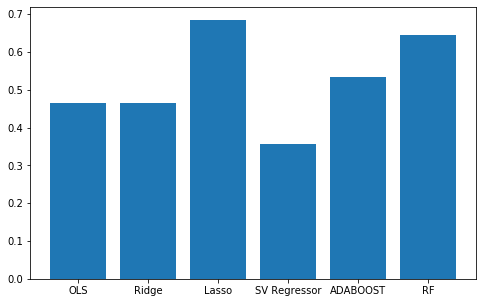

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(*zip(*results.items()))
plt.show()

In [12]:
results = []
for i in range(0, 60, 5): 
    time_chunk = i/100
    print("time_chunk:" + str(time_chunk) + " starts")
    df_ml = df_positive[:int(round(df_positive.shape[0] * (time_chunk + 0.4)))]
    X = df_ml.loc[:, df_ml.columns != target].values
    y = df_ml.loc[:,[target]].values
    div = int(round(len(X) * 0.29))
    X_test = X[:div]
    y_test = y[:div]
    X_train = X[div:]
    y_train = y[div:]
    rf = RandomForestRegressor(n_estimators = 100, random_state = 1) #the best one
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    preds = [1 if val > 0.5 else 0 for val in y_pred]
    try:
        roc = roc_auc_score(y_test, y_pred)
    except:
        roc = 0
    conf_mat = metrics.confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    results.append({
    "roc" : roc,
    "accuracy" : accuracy,
    "conf_mat" : conf_mat,
    "time_chunk" : time_chunk
    })

time_chunk:0.0 starts
time_chunk:0.05 starts
time_chunk:0.1 starts
time_chunk:0.15 starts
time_chunk:0.2 starts
time_chunk:0.25 starts
time_chunk:0.3 starts
time_chunk:0.35 starts
time_chunk:0.4 starts
time_chunk:0.45 starts
time_chunk:0.5 starts
time_chunk:0.55 starts


In [13]:
results_df = pd.DataFrame(results)
results_df

,accuracy,conf_mat,roc,time_chunk
0,0.571429,"[[8, 7], [5, 8]]",0.553846,0.00
1,0.687500,"[[13, 6], [4, 9]]",0.589069,0.05
2,0.542857,"[[9, 11], [5, 10]]",0.591667,0.10
3,0.641026,"[[16, 4], [10, 9]]",0.713158,0.15
4,0.547619,"[[10, 12], [7, 13]]",0.579545,0.20
5,0.608696,"[[18, 5], [13, 10]]",0.612476,0.25
6,0.551020,"[[15, 10], [12, 12]]",0.550000,0.30
7,0.622642,"[[19, 7], [13, 14]]",0.644587,0.35
8,0.589286,"[[20, 8], [15, 13]]",0.620536,0.40
9,0.550000,"[[19, 11], [16, 14]]",0.647778,0.45


In [14]:
print(results_df.accuracy.mean())

0.5792321977962018


Post Covid period

'date_filter':{"start_date":"2020-04-06T00:00:00.000Z",
                     "end_date":"2020-12-04T0:00:00.000Z"}

In [15]:
# pre-period 4/6/20~12/4/20
# Specify the action
action = 'API_getObservationsFromDataset'
# Specify your Token 
token = '5fcf7b349516296fad52cb7502QLyBLsCWOGE3W7rcOb6lv3IdplI7'

interval = 60 * 60 * 24 # One day
parameters = { 
 'token' : token,
    ##'id_dataset':'5d4ca8709516290b01c9d725', #microsoft
    'id_dataset':'5d4c39d09516290b01c8307b', #apple
    'date_filter':{"start_date":"2020-04-06T00:00:00.000Z",
                     "end_date":"2020-12-04T0:00:00.000Z"},
    'aggregate_in_time_interval' : {
              'time_interval_size' : interval, 
              'output' : 'avg', 
              'empty_intervals' : 'impute'
      }
}
        
# Pull the data into a Pandas Dataframe
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False)
df.reset_index(drop=True, inplace=True)
df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]
#df = df.drop('timestamp', axis = 1)
#df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]
#df = df.drop('timestamp', axis = 1)


Task ID: '5fcf7c220895fafb4a9d8d4b'.
Total estimated consumption: 5857.3 processing units.
Task confirmed. Starting download..
100.0 % completed.


In [16]:
positive_filter = {'name' : 'apple', 
                   'match_ngrams': ['apple', 'iphone', 'ipad', 
                                    'tim cook', 'mac store','mac','silicon']}

# We need to pass the 'id_dataset', the name of the
# column (which is 'text') and an optional filter.
blend_source = {
                'id_dataset':'5e2ef74e9516294390e810a9',#Wall Street Journal Twitter
                'feature' : 'text',
                'filter_text' : positive_filter
            }
df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = df.timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list')
df_anchor = pd.concat([df, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
df_anchor.head()

Task ID: '5fcf7c2b0895fafb4a9d8d4c'.
Total estimated consumption: 9680.0 processing units.
Task confirmed. Starting download..
100%


,change,count_agg,high,low,open,price,timestamp,date,WALL_STREE.text_COUNT_last1days:apple,WALL_STREE.text_last1days:apple
0,0.290000,1,123.37,120.920000,122.150000,123.080000,1606953600,03-12-2020 00:00:00,1,[a group of engineers macgyvered a ventilator ...
1,3.080000,1,123.47,120.010000,121.010000,122.720000,1606867200,02-12-2020 00:00:00,1,[the trump administration branded a russian wh...
2,-2.346667,0,117.98,114.943333,117.646667,115.013333,1606089600,23-11-2020 00:00:00,0,[]
3,1.200000,1,515.14,495.740000,514.790000,503.430000,1598313600,25-08-2020 00:00:00,0,[]
4,2.516667,0,509.91,489.560000,502.526667,501.446667,1598227200,24-08-2020 00:00:00,0,[]


In [17]:
start_time = timeit.default_timer()
blend_source = { 
                'id_textVectorizer':'5fcf36029516296fad52c8f2'
               }

df_blend = OpenBlender.timeBlend( token = token,
                                  anchor_ts = df_anchor.timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior_strict') .add_prefix('VEC.')                                  
df_anchor = pd.concat([df_anchor, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
print(timeit.default_timer() - start_time)
df_anchor.head()

Task ID: '5fcf7c530895fafb4a9d8d4c'.
Total estimated consumption: 149535.54 processing units.
Task confirmed. Starting download..
100%
138.81486909999876


,change,count_agg,high,low,open,price,timestamp,date,WALL_STREE.text_COUNT_last1days:apple,WALL_STREE.text_last1days:apple,...,VEC.youngest,VEC.youtube,VEC.youve,VEC.youve quoted,VEC.zach,VEC.zealand,VEC.zone,VEC.zoo,VEC.zoom,VEC.zuckerberg
0,0.290000,1,123.37,120.920000,122.150000,123.080000,1606953600,03-12-2020 00:00:00,1,[a group of engineers macgyvered a ventilator ...,...,0,7,0,0,0,0,0,0,4,0
1,3.080000,1,123.47,120.010000,121.010000,122.720000,1606867200,02-12-2020 00:00:00,1,[the trump administration branded a russian wh...,...,0,0,0,0,0,0,0,77,20,0
2,-2.346667,0,117.98,114.943333,117.646667,115.013333,1606089600,23-11-2020 00:00:00,0,[],...,0,0,0,0,0,13,0,0,24,0
3,1.200000,1,515.14,495.740000,514.790000,503.430000,1598313600,25-08-2020 00:00:00,0,[],...,0,0,0,0,0,0,0,0,0,0
4,2.516667,0,509.91,489.560000,502.526667,501.446667,1598227200,24-08-2020 00:00:00,0,[],...,0,0,0,0,0,0,7,0,5,0


In [18]:
df_anchor.shape

(242, 4898)

In [19]:
# Where ‘change’ decreased more than 0.5%
df_anchor['negative_poc'] = [1 if log_diff < -0.005 else 0 for log_diff in df_anchor['change']]
# Where ‘change’ increased more than 0.5%
df_anchor['positive_poc'] = [1 if log_diff > 0.005 else 0 for log_diff in df_anchor['change']]
# We need to shift our target one day so that we predict 
# for what will happen 'tomorrow' with news and data from 'today'
df_anchor['target'] = df_anchor['positive_poc'].shift(-1)
df_anchor[['change', 'positive_poc', 'target']].head(3)

,change,positive_poc,target
0,0.290000,1,1.0
1,3.080000,1,0.0
2,-2.346667,0,1.0


In [20]:
df_anchor = df_anchor[:-1] # Remove the last one with NaN
# Define target
target = 'target'
df_positive = df_anchor[1:].select_dtypes(['number'])
# Create train/test sets
X = df_positive.loc[:, df_positive.columns != target].values
y = df_positive.loc[:,[target]].values
div = int(round(len(X) * 0.7)) #prop for training set
X_train = X[:div]
y_train = y[:div]
X_test = X[div:]
y_test = y[div:]

print('Train:')
print(X_train.shape)
print(y_train.shape)
print('Test:')
print(X_test.shape)
print(y_test.shape)

Train:
(168, 4897)
(168, 1)
Test:
(72, 4897)
(72, 1)


In [23]:
# Compare Algorithms
seed = 0
# prepare models
models = []
models.append(('OLS', linear_model.LinearRegression()))
models.append(('Ridge', linear_model.Ridge(alpha=0.1)))
models.append(('Lasso', linear_model.Lasso(alpha=0.1)))
models.append(('SV Regressor', svm.SVR()))
models.append(('ADABOOST', AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=seed)))
models.append(('RF', RandomForestRegressor(n_estimators = 200, random_state = seed)))


# evaluate each model in turn
results = dict()

scoring = 'accuracy'
for name, model in models:
    mod = model
    mod.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds = [1 if val > 0.5 else 0 for val in y_pred]
    results[name] = round(accuracy_score(y_test, preds),3)


# print("AUC score:")
# print(roc_auc_score(y_test, y_pred))

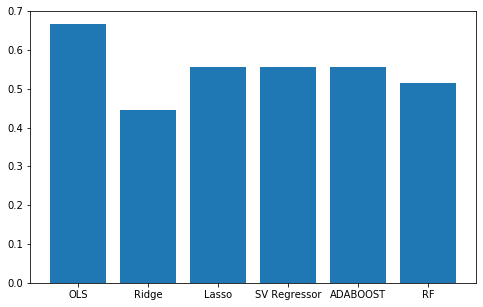

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(*zip(*results.items()))
plt.show()

In [25]:
results = []
for i in range(0, 60, 5): 
    time_chunk = i/100
    print("time_chunk:" + str(time_chunk) + " starts")
    df_ml = df_positive[:int(round(df_positive.shape[0] * (time_chunk + 0.4)))]
    X = df_ml.loc[:, df_ml.columns != target].values
    y = df_ml.loc[:,[target]].values
    div = int(round(len(X) * 0.29))
    X_test = X[:div]
    y_test = y[:div]
    X_train = X[div:]
    y_train = y[div:]
    rf = RandomForestRegressor(n_estimators = 100, random_state = 1) #the best one
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    preds = [1 if val > 0.5 else 0 for val in y_pred]
    try:
        roc = roc_auc_score(y_test, y_pred)
    except:
        roc = 0
    conf_mat = metrics.confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    results.append({
    "roc" : roc,
    "accuracy" : accuracy,
    "conf_mat" : conf_mat,
    "time_chunk" : time_chunk
    })

time_chunk:0.0 starts
time_chunk:0.05 starts
time_chunk:0.1 starts
time_chunk:0.15 starts
time_chunk:0.2 starts
time_chunk:0.25 starts
time_chunk:0.3 starts
time_chunk:0.35 starts
time_chunk:0.4 starts
time_chunk:0.45 starts
time_chunk:0.5 starts
time_chunk:0.55 starts


In [26]:
results_df = pd.DataFrame(results)
results_df

,accuracy,conf_mat,roc,time_chunk
0,0.464286,"[[7, 1], [14, 6]]",0.606250,0.00
1,0.516129,"[[3, 6], [9, 13]]",0.540404,0.05
2,0.514286,"[[6, 6], [11, 12]]",0.586957,0.10
3,0.631579,"[[8, 6], [8, 16]]",0.629464,0.15
4,0.714286,"[[6, 9], [3, 24]]",0.701235,0.20
5,0.555556,"[[5, 13], [7, 20]]",0.521605,0.25
6,0.653061,"[[4, 16], [1, 28]]",0.531897,0.30
7,0.653846,"[[4, 16], [2, 30]]",0.588281,0.35
8,0.571429,"[[4, 18], [6, 28]]",0.554813,0.40
9,0.644068,"[[6, 16], [5, 32]]",0.622850,0.45


In [27]:
print(results_df.accuracy.mean())

0.5925970930878806
